In [1]:
# system packages 
import os 
import glob 
import pathlib as Path

# python data and visualization packages
import numpy as np
import natsort  # For natural sorting of file paths
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

# image processing packages 
import cv2
import imageio.v2 as imageio
import skimage.io
from skimage.transform import resize

# machine learning libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
# Display
pd.set_option('display.float_format', '{:.2f}'.format)

## Prepare data

In [10]:
# image dataframe
train_prq_path = "oil_spill_training_dataset.parquet"
val_prq_path = "oil_spill_validation_dataset.parquet"
datasets_2 = "oil_spill_training_dataset-2.parquet"
train_df = pd.read_parquet(train_prq_path)
train_df = pd.read_parquet(val_prq_path)
train_df_2 = pd.read_parquet(datasets_2)
train_df.shape, val_df.shape, train_df_2.shape

((10444800, 3), (10444800, 3), (92160000, 5))

In [6]:
train_df.describe()

,Red,labels,glcm
count,92160000.00,92160000.00,92160000.00
mean,0.52,0.18,1.00
std,0.24,0.57,5.47
min,0.00,0.00,0.00
25%,0.35,0.00,0.00
50%,0.51,0.00,0.00
75%,0.69,0.00,1.00
max,1.00,4.00,24470.00


In [8]:
train_df, val_df

(          Red  labels  glcm
 0        0.65       0     0
 1        0.98       0     0
 2        0.68       0     0
 3        0.65       0     0
 4        0.78       0     0
 ...       ...     ...   ...
 92159995 0.36       0     0
 92159996 0.39       0     0
 92159997 0.44       0     0
 92159998 0.36       0     0
 92159999 0.32       0     0
 
 [92160000 rows x 3 columns],
           Red  labels  glcm
 0        0.53       0    13
 1        0.94       0     0
 2        0.69       0     0
 3        0.69       0     2
 4        0.71       0     0
 ...       ...     ...   ...
 10444795 0.35       0     0
 10444796 0.34       0     0
 10444797 0.41       0     0
 10444798 0.41       0     0
 10444799 0.47       0     0
 
 [10444800 rows x 3 columns])

## Model Development 

### Model-1: Channel & Texture Feature Based

#### Train/Validation Feature & Target

In [5]:
X_train = train_df[['chnl_red', 'glcm']]
y_train = train_df['labels']

X_valid = val_df[['chnl_red', 'glcm']]
y_valid = val_df['labels']

KeyError: "['chnl_red'] not in index"

#### Resampling by class of training dataset 

In [5]:
# image dataframe
train_prq_path = "oil_spill_training_dataset.parquet"
val_prq_path = "oil_spill_validation_dataset.parquet"
datasets_2 = "oil_spill_training_dataset-2.parquet"
train_df = pd.read_parquet(train_prq_path)
train_df = pd.read_parquet(val_prq_path)
train_df_2 = pd.read_parquet(datasets_2)
train_df.shape, val_df.shape, train_df_2.shape

In [6]:
%%time
# Create an undersampler
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy_dict, random_state=42)

# Resample the dataset
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [47]:
X_train.shape, X_train_resampled.shape

((92160000, 2), (20439031, 2))

In [48]:
y_train_resampled.value_counts()

0    13358844
1     5343538
2     1335884
3      333971
4       66794
Name: labels, dtype: int64

In [49]:
y_train.value_counts()

0    81732526
1     6679422
2     1897974
3     1597893
4      252185
Name: labels, dtype: int64

#### Model building 

In [50]:
%%time
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0, n_jobs=-1)
# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

CPU times: user 5h 18min 8s, sys: 7min 44s, total: 5h 25min 53s
Wall time: 5min 45s


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)

In [51]:
%%time
# Make predictions on the validation set
y_pred = rf_model.predict(X_valid)

# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred)
# Generate a classification report
report = classification_report(y_valid, y_pred)
print(f'Overall Accuracy of base model:{accuracy}')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Accuracy of base model:0.8680004404105393
CPU times: user 7min 12s, sys: 1min 5s, total: 8min 18s
Wall time: 40.2 s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Accuracy Assessment 

In [52]:
report_data = []
lines = report.split('\n')
for line in lines[2:-3]:  # Skip header and footer lines
    row_data = line.split()
    if len(row_data) == 5:
        class_name = row_data[0]
        precision, recall, f1_score, support = [float(val) for val in row_data[1:]]
        report_data.append({'Class': class_name, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score, 'Support': support})

# Create a DataFrame from the list of dictionaries
report_df = pd.DataFrame(report_data)

report_df

,Class,Precision,Recall,F1-Score,Support
0,0,0.92,0.94,0.93,9337961.00
1,1,0.32,0.38,0.34,816494.00
2,2,0.22,0.00,0.00,154361.00
3,3,0.04,0.00,0.00,96344.00
4,4,0.00,0.00,0.00,39640.00


In [125]:
idx=320*320
np.unique(y_pred[idx*23:idx*24]), np.unique(y_valid[idx*23:idx*24])

(array([0, 1], dtype=uint8), array([0, 1, 2], dtype=uint8))

In [1]:
idx = 102400
image_shape = (320, 320)
image_pred = y_pred[idx*22:idx*23].reshape(image_shape)
plt.imshow(image_pred)

NameError: name 'y_pred' is not defined

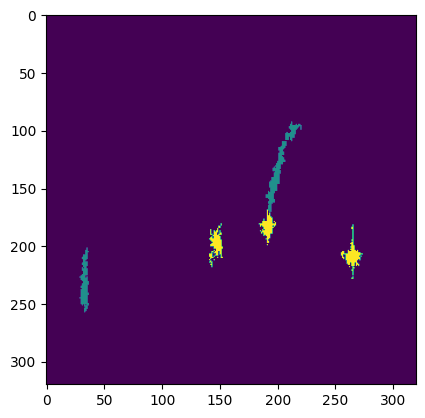

In [149]:
plt.imshow(np.array(y_valid[idx*75:idx*76]).reshape(image_shape))

In [ ]:
np.unique(image_pred-1), np.unique(np.array(y_valid[idx*2:idx*3]).reshape(image_shape))

### Model-2: Filter feature based

#### Train Model calculation 

In [ ]:
train_df.columns, val_df.shape

In [68]:
X_st_train = train_df[['chnl_red', 'filter_red', 'ers_red', 'glcm']]
y_st_train = train_df['labels']

X_st_val = val_df[['chnl_red', 'filter_red', 'ers_red', 'glcm']]
y_st_val = val_df['labels']

In [ ]:
sampling_strategy_dict = {
    0: y_train.values()[1]*2,
    1:round(y_train.values()[1]*0.8)
    2:round(y_train.values()[1]*0.2)
    3:round(y_train.values()[1]*0.05)
    4:round(y_train.values()[1]*0.01)
}
    

In [69]:
%%time
# Create an undersampler
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy_dict, random_state=42)

# Resample the dataset
X_st_train_resampled, y_st_train_resampled = undersampler.fit_resample(X_st_train, y_st_train)

CPU times: user 27.7 s, sys: 4.43 s, total: 32.2 s
Wall time: 32.1 s


In [70]:
X_st_train_resampled.shape

(20439031, 4)

In [71]:
y_st_train_resampled.value_counts()

0    13358844
1     5343538
2     1335884
3      333971
4       66794
Name: labels, dtype: int64

In [72]:
%%time
st_rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0, n_jobs=-1)
st_rf_model.fit(X_st_train_resampled, y_st_train_resampled)
# Make predictions on the validation set
y_st_pred = st_rf_model.predict(X_st_val)

CPU times: user 9h 52min 59s, sys: 10min 46s, total: 10h 3min 46s
Wall time: 10min 17s


In [73]:
# Calculate accuracy
st_accuracy = accuracy_score(y_st_val, y_st_pred)
# Generate a classification report
st_report = classification_report(y_st_val, y_st_pred)
st_accuracy

0.8770795036764706

In [74]:
st_report_data = []
lines = st_report.split('\n')
for line in lines[2:-3]:  # Skip header and footer lines
    row_data = line.split()
    if len(row_data) == 5:
        class_name = row_data[0]
        precision, recall, f1_score, support = [float(val) for val in row_data[1:]]
        st_report_data.append({'Class': class_name, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score, 'Support': support})

# Create a DataFrame from the list of dictionaries
st_report_df = pd.DataFrame(st_report_data)

st_report_df

,Class,Precision,Recall,F1-Score,Support
0,0,0.94,0.94,0.94,9337961.00
1,1,0.37,0.47,0.42,816494.00
2,2,0.32,0.19,0.23,154361.00
3,3,0.02,0.00,0.00,96344.00
4,4,0.02,0.00,0.00,39640.00


In [124]:
np.unique(y_st_pred[idx*39:idx*40])

array([0, 1, 2], dtype=uint8)

In [122]:
np.unique(y_st_val[idx*39:idx*40])

array([0, 1], dtype=uint8)

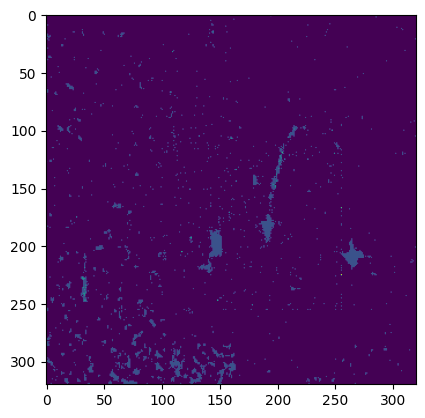

In [150]:
idx = 102400
image_shape = (320, 320)
image_pred = y_st_pred[idx*75:idx*76].reshape(image_shape)
plt.imshow(image_pred)

In [151]:
np.unique(y_st_pred[idx*75:idx*76]), np.unique(y_st_val[idx*75:idx*76])

(array([0, 1, 2, 3, 4], dtype=uint8), array([0, 1, 2], dtype=uint8))

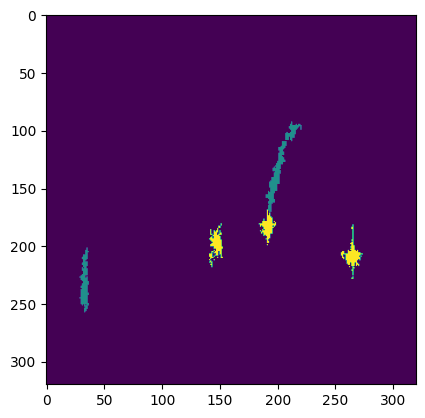

In [152]:
plt.imshow(np.array(y_st_val[idx*75:idx*76]).reshape(image_shape))

### Model Tuning 

In [153]:
%%time
st_rf_model5 = RandomForestClassifier(n_estimators=500, max_depth=None, random_state=44, n_jobs=-1)
st_rf_model5.fit(X_st_train_resampled, y_st_train_resampled)


CPU times: user 1d 49min 37s, sys: 18min 42s, total: 1d 1h 8min 20s
Wall time: 23min 24s


In [157]:
# Make predictions on the validation set
y_st_pred5 = st_rf_model5.predict(X_st_val)
# Calculate accuracy
st5_accuracy = accuracy_score(y_st_val, y_st_pred5)
# Generate a classification report
st5_report = classification_report(y_st_val, y_st_pred5)
st5_accuracy

0.8770300053615196

In [158]:
st5_report_data = []
lines = st5_report.split('\n')
for line in lines[2:-3]:  # Skip header and footer lines
    row_data = line.split()
    if len(row_data) == 5:
        class_name = row_data[0]
        precision, recall, f1_score, support = [float(val) for val in row_data[1:]]
        st5_report_data.append({'Class': class_name, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score, 'Support': support})

# Create a DataFrame from the list of dictionaries
st5_report_df = pd.DataFrame(st5_report_data)

st5_report_df

,Class,Precision,Recall,F1-Score,Support
0,0,0.94,0.94,0.94,9337961.00
1,1,0.37,0.47,0.42,816494.00
2,2,0.32,0.19,0.23,154361.00
3,3,0.02,0.00,0.00,96344.00
4,4,0.02,0.00,0.00,39640.00


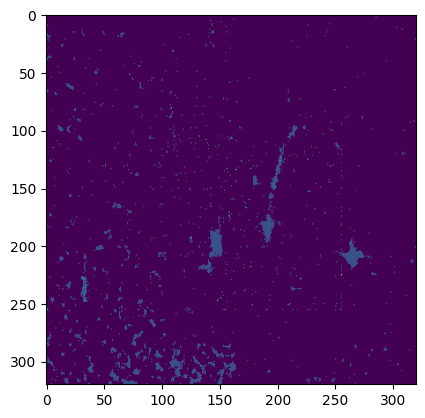

In [159]:
image_pred5 = y_st_pred5[idx*75:idx*76].reshape(image_shape)
plt.imshow(image_pred5)